## Weather forecasting ensemble exploration, evaluation & training

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Define time range of exploration to 12 hour period from 2024-12-07 12:00:00+00:00 to 2024-12-08 00:00:00+00:00

In [107]:
start_time = pd.Timestamp('2024-12-07 12:00:00', tz='UTC')
end_time = start_time + pd.Timedelta(hours=12)
print(start_time, end_time)

2024-12-07 12:00:00+00:00 2024-12-08 00:00:00+00:00


In [108]:
def get_forecast_df():
    '''
    This function returns a filtered (12 hour forward) dataframe from a locally gathered forecast dataset generated by running the simple MEAN model.
    This dataset was gathered one day before this 12 hour forecast period.
    '''
    df_forecast = pd.read_csv('../local_data/exports/Athens_ENSEMBLE_simple_average_2024-12-07134005268602.csv')
    df_forecast = df_forecast[df_forecast.source != 'ensemble']
    df_forecast['time'] = pd.to_datetime(df_forecast['time'])
    df_forecast = df_forecast[(df_forecast['time'] >= start_time) & (df_forecast['time'] <= end_time)]
    return df_forecast

In [109]:
df_forecast = get_forecast_df()
df_forecast.head()


,Unnamed: 0,time,feels_like,relative_humidity,precipitation_probability,temperature_c,wind_direction,wind_speed,source
1,1,2024-12-07 12:00:00+00:00,15.74,0.0,0.0,15.74,173.0,2.72,tomorrowapi
2,2,2024-12-07 13:00:00+00:00,15.66,0.0,0.0,15.66,179.0,3.02,tomorrowapi
3,3,2024-12-07 14:00:00+00:00,14.92,0.0,65.0,14.92,189.0,2.64,tomorrowapi
4,4,2024-12-07 15:00:00+00:00,14.40,0.0,45.0,14.40,185.0,2.89,tomorrowapi
5,5,2024-12-07 16:00:00+00:00,14.00,0.0,45.0,14.00,188.0,3.26,tomorrowapi


In [110]:
def get_historical_df():
    df_historical = pd.read_csv('../local_data/exports/HISTORICAL_export_2024-12-15150350295308.csv')
    cols = [col for col in df_historical if col != 'source']
    df_historical = df_historical[cols]
    df_historical['time'] = pd.to_datetime(df_historical['time'])
    df_historical = df_historical[(df_historical['time'] >= start_time) & (df_historical['time'] <= end_time)]
    return df_historical


In [111]:
df_historical = get_historical_df()
df_historical.head()


,Unnamed: 0,time,feels_like,relative_humidity,precipitation_probability,temperature_c,wind_direction,wind_speed
12,12,2024-12-07 12:00:00+00:00,16.44,62,3,17.89,197,19.59
13,13,2024-12-07 13:00:00+00:00,16.15,67,20,17.39,193,21.13
14,14,2024-12-07 14:00:00+00:00,15.96,71,60,16.84,191,22.38
15,15,2024-12-07 15:00:00+00:00,15.51,79,93,15.94,208,19.65
16,16,2024-12-07 16:00:00+00:00,15.29,87,95,15.14,207,15.46


In [112]:
def combine_dfs(df_forecast, df_historical):
    merged_df = pd.merge(df_forecast, df_historical, on="time", suffixes=("_forecast", "_obs"), how='left')
    return merged_df

### Evaluation of each model to generate weights for weighted average

In [115]:
def combine_and_calculate_mae(df_forecast, df_historical):
    merged_df = combine_dfs(df_forecast, df_historical)
    columns_to_evaluate = ["feels_like", "relative_humidity", "precipitation_probability", 
                       "temperature_c", "wind_direction", "wind_speed"]

    errors_per_model = {}

    for source, group in merged_df.groupby("source"):
        # Calculate error metrics (Mean Absolute Error in this case)
        mae = {}
        for col in columns_to_evaluate:
            mae[col] = np.mean(np.abs(group[f"{col}_forecast"] - group[f"{col}_obs"]))
        # Store the average MAE across all columns for the source
        errors_per_model[source] = np.mean(list(mae.values()))

    errors_df = pd.DataFrame(list(errors_per_model.items()), columns=["source", "average_mae"])

    # Calculate weights inversely proportional to the errors
    errors_df["weight"] = 1 / errors_df["average_mae"]
    errors_df["weight"] /= errors_df["weight"].sum()  # Normalize weights to sum to 1

    return errors_df

In [118]:
errors_df = combine_and_calculate_mae(df_forecast, df_historical)
errors_df.head()
#SAVE WEIGHTS TO CONFIGURATION FILE WHICH IS USED BY THE LIVE APPLICATION
errors_df[['source','weight']].set_index('source').to_json('../data/model_weights.json')

,source,average_mae,weight
0,accuweather,8.394583,0.290937
1,openmeteo,3.994744,0.611377
2,tomorrowapi,25.001538,0.097686


In [124]:
merged_df = combine_dfs(df_forecast, df_historical)

In [125]:
merged_df.to_csv('../local_data/exports/COMBINED.csv')

In [127]:
merged_df.head()

,Unnamed: 0_forecast,time,feels_like_forecast,relative_humidity_forecast,precipitation_probability_forecast,temperature_c_forecast,wind_direction_forecast,wind_speed_forecast,source,Unnamed: 0_obs,feels_like_obs,relative_humidity_obs,precipitation_probability_obs,temperature_c_obs,wind_direction_obs,wind_speed_obs
0,1,2024-12-07 12:00:00+00:00,15.74,0.0,0.0,15.74,173.0,2.72,tomorrowapi,12,16.44,62,3,17.89,197,19.59
1,2,2024-12-07 13:00:00+00:00,15.66,0.0,0.0,15.66,179.0,3.02,tomorrowapi,13,16.15,67,20,17.39,193,21.13
2,3,2024-12-07 14:00:00+00:00,14.92,0.0,65.0,14.92,189.0,2.64,tomorrowapi,14,15.96,71,60,16.84,191,22.38
3,4,2024-12-07 15:00:00+00:00,14.40,0.0,45.0,14.40,185.0,2.89,tomorrowapi,15,15.51,79,93,15.94,208,19.65
4,5,2024-12-07 16:00:00+00:00,14.00,0.0,45.0,14.00,188.0,3.26,tomorrowapi,16,15.29,87,95,15.14,207,15.46


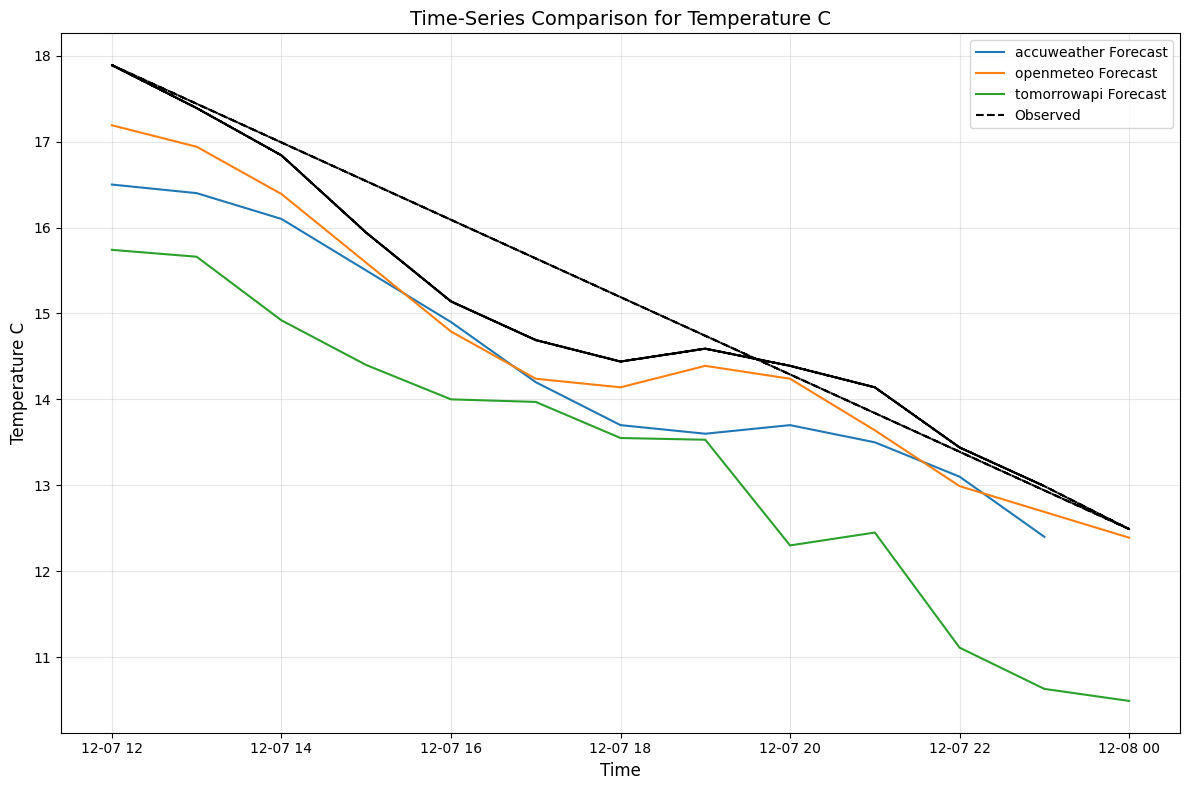

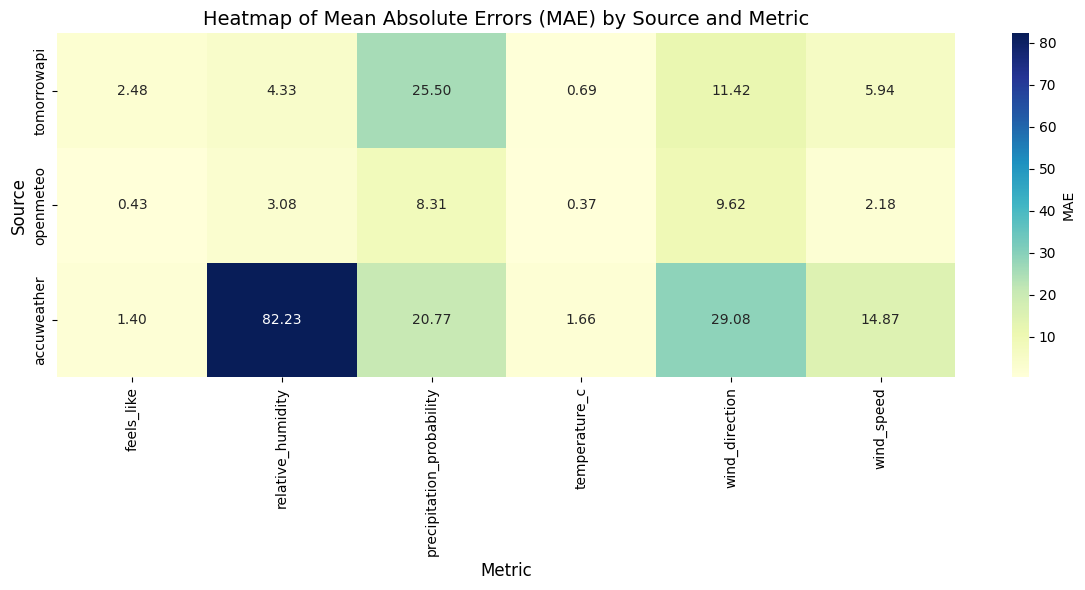

In [130]:
# 1. Define the columns to evaluate
columns_to_evaluate = [
    "feels_like", "relative_humidity", "precipitation_probability", 
    "temperature_c", "wind_direction", "wind_speed"
]

# 2. Time-series comparison for one or more columns (e.g., temperature_c)
selected_column = "temperature_c"

# Create the plot for time-series comparison
plt.figure(figsize=(12, 8))

# Plot the forecasts for each source
for source, group in merged_df.groupby("source"):
    plt.plot(group["time"], group[f"{selected_column}_forecast"], label=f"{source} Forecast")

# Add the observed data to the plot
plt.plot(merged_df["time"], merged_df[f"{selected_column}_obs"], 
         label="Observed", linestyle="--", color="black")

# Customize plot appearance
plt.title(f"Time-Series Comparison for {selected_column.replace('_', ' ').title()}", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel(f"{selected_column.replace('_', ' ').title()}", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Heatmap of MAE for each column per source

# Calculate the Mean Absolute Error (MAE) for each column
mae_matrix = []
for source, group in merged_df.groupby("source"):
    mae_row = [
        np.mean(np.abs(group[f"{col}_forecast"] - group[f"{col}_obs"])) 
        for col in columns_to_evaluate
    ]
    mae_matrix.append(mae_row)

# Create a DataFrame for the MAE matrix
mae_df = pd.DataFrame(mae_matrix, columns=columns_to_evaluate, 
                      index=merged_df["source"].unique())

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(mae_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'MAE'})

# Customize heatmap appearance
plt.title("Heatmap of Mean Absolute Errors (MAE) by Source and Metric", fontsize=14)
plt.ylabel("Source", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.tight_layout()
plt.show()
